# Relationship Extraction

This notebook is similar to `05-nyt-re-bert.ipynb` except that implements scenario (b) in the slides, i.e., we use the subject and object entity spans **without** the entity markers. 

Working without entity markers is implemented by marking the start and end tokens of entity spans using a special character, and then extracting the span indexes in the raw dataset itself (since the information is no longer available by the time we go to the encoded dataset).

As noted also in the [Matching the Blanks paper](https://arxiv.org/abs/1906.03158), this model does not perform as well as the models implementing scenario (e) and (f).

In [1]:
!pip install transformers datasets seqeval

## Imports

In [2]:
import collections
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random
import re
import shutil
import torch
import torch.nn as nn

from collections import Counter, defaultdict
from datasets import load_dataset, ClassLabel
from sklearn.metrics import (
    ConfusionMatrixDisplay, confusion_matrix, 
    classification_report, accuracy_score
)
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.optim import AdamW

from transformers import (
    BertTokenizerFast, BertModel, BertForPreTraining, BertConfig, BertPreTrainedModel,
    DataCollatorWithPadding,
    get_scheduler
)
from transformers.modeling_outputs import SequenceClassifierOutput

## Mount Google Drive

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
GS_INPUT_DIR = "/content/drive/MyDrive/odsc-2022-data/NYT"
DATA_DIR = "./data"

BASE_MODEL_NAME = "bert-base-cased"
MODEL_DIR = os.path.join(DATA_DIR, "{:s}-nyt-re-v2".format(BASE_MODEL_NAME))

SUB_MARK = "\u00b9"
OBJ_MARK = "\u00b2"

In [5]:
!ls /content/drive/MyDrive/odsc-2022-data/NYT/

bert-base-cased-nyt-re-v1  test.json   valid.json
bert-base-cased-nyt-re-v3  train.json


## Input Data Format

In [6]:
with open(os.path.join(GS_INPUT_DIR, "train.json"), "r") as fin:
  for line in fin:
    rec = json.loads(line.strip())
    break

print(json.dumps(rec, indent=2))

{
  "sentText": "Massachusetts ASTON MAGNA Great Barrington ; also at Bard College , Annandale-on-Hudson , N.Y. , July 1-Aug .",
  "articleId": "/m/vinci8/data1/riedel/projects/relation/kb/nyt1/docstore/nyt-2005-2006.backup/1669365.xml.pb",
  "relationMentions": [
    {
      "em1Text": "Annandale-on-Hudson",
      "em2Text": "Bard College",
      "label": "/location/location/contains"
    }
  ],
  "entityMentions": [
    {
      "start": 1,
      "label": "ORGANIZATION",
      "text": "Bard College"
    },
    {
      "start": 2,
      "label": "LOCATION",
      "text": "Annandale-on-Hudson"
    }
  ],
  "sentId": "1"
}


## Entity Types

In [7]:
splits = ["train", "valid", "test"]
ent_counts = collections.defaultdict(collections.Counter)
for split in splits:
  with open(os.path.join(GS_INPUT_DIR, "{:s}.json".format(split)), "r") as fin:
    for json_line in fin:
      json_dict = json.loads(json_line.strip())
      for ent_mention in json_dict["entityMentions"]:
        label = ent_mention["label"]
        ent_counts[label][split] += 1

ent_df = pd.DataFrame.from_dict(ent_counts, orient="index").sort_values("train", ascending=False)
ent_df

,train,valid,test
LOCATION,119693,10703,10721
PERSON,41367,3727,3727
ORGANIZATION,16401,1493,1413


## Relation Types

In [8]:
rel_counts = collections.defaultdict(collections.Counter)
for split in splits:
  with open(os.path.join(GS_INPUT_DIR, "{:s}.json".format(split)), "r") as fin:
    for json_line in fin:
      json_dict = json.loads(json_line.strip())
      for ent_mention in json_dict["relationMentions"]:
        label = ent_mention["label"].split("/")[-1]
        rel_counts[label][split] += 1

rel_df = pd.DataFrame.from_dict(rel_counts, orient="index").sort_values("train", ascending=False)
rel_df = rel_df[(rel_df["train"] > 1000) & (rel_df["train"] < 10000)]
rel_df

,train,valid,test
nationality,7198,643.0,589.0
capital,6718,616.0,708.0
place_lived,6362,539.0,612.0
country,5658,558.0,580.0
administrative_divisions,5658,558.0,580.0
company,4950,466.0,436.0
neighborhood_of,4941,469.0,394.0
place_of_birth,2813,228.0,270.0
place_of_death,1752,133.0,136.0


## Raw Dataset

In models for scenarios (e) and (f), we have simply extracted the tokens and tags in this step, and inserted entity markers within the tokens.

Here since we are not going to provide entity markers, we will use similar logic to mark the start and end tokens in the subject and object span as we parse the file, then post-process the tokens to retrieve the span indexes (and reset the tokens).

In [9]:
def reformat_json(infile, outfile, valid_relations):
  print("reformating {:s} -> {:s}".format(infile, outfile))
  fout = open(outfile, "w")
  with open(infile, "r") as fin:
    for line in fin:
      rec = json.loads(line.strip())
      text = rec["sentText"]
      entities = {}
      for entity_mention in rec["entityMentions"]:
        entity_text = entity_mention["text"]
        entity_type = entity_mention["label"][0:3]
        entities[entity_text] = entity_type
      for relation_mention in rec["relationMentions"]:
        label = relation_mention["label"].split("/")[-1]
        if label not in valid_relations:
          continue
        try:
          sub_text = relation_mention["em1Text"]
          sub_type = entities[sub_text]
          obj_text = relation_mention["em2Text"]
          obj_type = entities[obj_text]
          
          # assumption: em1Text == SUBJECT and occurs before em2Text == OBJECT
          sub_start = text.find(sub_text)
          sub_end = sub_start + len(sub_text)
          text_pre = text[:sub_start]
          text_sub = "{:s}{:s}{:s}".format(SUB_MARK, sub_text, SUB_MARK)
          obj_start = text.find(obj_text, sub_end)
          obj_end = obj_start + len(obj_text)
          text_mid = text[sub_end:obj_start]
          text_obj = "{:s}{:s}{:s}".format(OBJ_MARK, obj_text, OBJ_MARK)
          text_post = text[obj_end:]
          text = text_pre + text_sub + text_mid + text_obj + text_post

          tokens = text.split()
          span_idxs = [
            [i for i, tok in enumerate(tokens) if tok.startswith(SUB_MARK)][0],
            [i for i, tok in enumerate(tokens) if tok.endswith(SUB_MARK)][0],
            [i for i, tok in enumerate(tokens) if tok.startswith(OBJ_MARK)][0],
            [i for i, tok in enumerate(tokens) if tok.endswith(OBJ_MARK)][0]
          ]
          if span_idxs[0] > span_idxs[1] or span_idxs[2] > span_idxs[3]:
            continue
          clean_tokens = [tok.replace(SUB_MARK, "").replace(OBJ_MARK, "") for tok in tokens]
          output = {
              "tokens": clean_tokens,
              "label": label,
              "span_idxs": span_idxs
          }
          
          fout.write(json.dumps(output) + "\n")
        except Exception as e:
          # raise e
          pass
  fout.close()


os.makedirs(DATA_DIR, exist_ok=True)

valid_relations = set([
  "nationality", "capital", "place_lived", "country", "administrative_divisions",
  "company", "neighborhood_of", "place_of_birth", "place_of_death"
])

for i, split in enumerate(splits):
  reformat_json(os.path.join(GS_INPUT_DIR, "{:s}.json".format(split)),
                os.path.join(DATA_DIR, "{:s}.json".format(split)), 
                valid_relations=valid_relations)

reformating /content/drive/MyDrive/odsc-2022-data/NYT/train.json -> ./data/train.json
reformating /content/drive/MyDrive/odsc-2022-data/NYT/valid.json -> ./data/valid.json
reformating /content/drive/MyDrive/odsc-2022-data/NYT/test.json -> ./data/test.json


In [10]:
data_files = {split: os.path.join(DATA_DIR, "{:s}.json".format(split)) for split in splits}
nyt_dataset = load_dataset("json", data_files=data_files)
nyt_dataset

Using custom data configuration default-4b7395031582caa7


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-4b7395031582caa7/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'label', 'span_idxs'],
        num_rows: 31986
    })
    valid: Dataset({
        features: ['tokens', 'label', 'span_idxs'],
        num_rows: 2916
    })
    test: Dataset({
        features: ['tokens', 'label', 'span_idxs'],
        num_rows: 3005
    })
})

### Label Distribution

In [11]:
nyt_dataset.set_format(type="pandas")
nyt_df = nyt_dataset["train"][:]
nyt_df.head()

,tokens,label,span_idxs
0,"[It, will, be, the, final, movie, credited, to...",place_of_birth,"[8, 9, 17, 17]"
1,"[Under, pressure, from, Mr., Kerkorian, and, o...",company,"[19, 20, 26, 26]"
2,"[Mr., Ferrer, still, holds, commanding, leads,...",place_lived,"[18, 20, 22, 22]"
3,"[Mr., Ferrer, still, holds, commanding, leads,...",place_lived,"[18, 20, 22, 22]"
4,"[United, States, Representative, Charles, B., ...",place_of_birth,"[3, 5, 16, 18]"


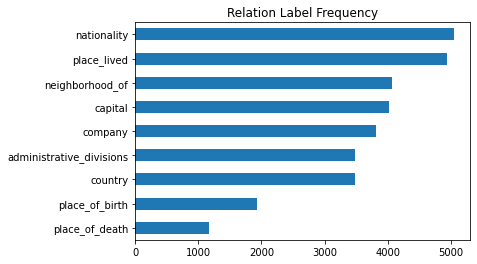

In [12]:
nyt_df["label"].value_counts(ascending=True).plot.barh()
plt.title("Relation Label Frequency")
_ = plt.show()

### Sentence Length Distribution

Box plots below shows that we can safely ignore sentences that are over 100 tokens in length.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


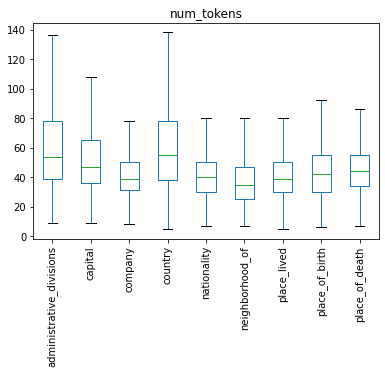

In [13]:
nyt_df["num_tokens"] = nyt_df["tokens"].apply(len)
nyt_df.boxplot("num_tokens", by="label", grid=False, showfliers=False)
plt.suptitle("")
plt.xlabel("")
plt.xticks(rotation=90)
_ = plt.show()

In [14]:
nyt_dataset.reset_format()

## Tokenizer

Note **no need to add marker tokens**!

In [15]:
tokenizer = BertTokenizerFast.from_pretrained(BASE_MODEL_NAME)

## Encoded Dataset

In [16]:
valid_relations = sorted(list(valid_relations))
rel_tags = ClassLabel(names=valid_relations)
label2id = {name: rel_tags.str2int(name) for name in valid_relations}
id2label = {id: rel_tags.int2str(id) for id in range(len(valid_relations))}

# label2id, id2label

In [17]:
def encode_data(examples):
  tokenized_inputs = tokenizer(examples["tokens"],
                               is_split_into_words=True,
                               truncation=True)
  span_idxs = []
  for input_id in tokenized_inputs.input_ids:
    tokens = tokenizer.convert_ids_to_tokens(input_id)
  tokenized_inputs["span_idxs"] = examples["span_idxs"]
  tokenized_inputs["labels"] = [label2id[label] for label in examples["label"]]
  return tokenized_inputs

encoded = encode_data(nyt_dataset["train"][0:5])
encoded.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'span_idxs', 'labels'])

In [18]:
MAX_LENGTH = 100
encoded_nyt_dataset = (nyt_dataset
                       .filter(lambda example: len(example["tokens"]) < MAX_LENGTH)
                       .map(encode_data, batched=True, remove_columns=["tokens", "label"]))
encoded_nyt_dataset

  0%|          | 0/32 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/31 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['span_idxs', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 30601
    })
    valid: Dataset({
        features: ['span_idxs', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2767
    })
    test: Dataset({
        features: ['span_idxs', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2844
    })
})

In [19]:
rec = encoded_nyt_dataset["train"][0:5]
print("rec.labels:", rec["labels"])
print("rec.input_ids:", len(rec["input_ids"]), len(rec["input_ids"][0]))
print("rec.span_idxs:", rec["span_idxs"])

rec.labels: [7, 2, 6, 6, 7]
rec.input_ids: 5 40
rec.span_idxs: [[8, 9, 17, 17], [19, 20, 26, 26], [18, 20, 22, 22], [18, 20, 22, 22], [3, 5, 16, 18]]


## DataLoader

In [20]:
BATCH_SIZE = 16

In [21]:
collate_fn = DataCollatorWithPadding(tokenizer, padding="longest", return_tensors="pt")

train_dl = DataLoader(encoded_nyt_dataset["train"], 
                      shuffle=True, 
                      # sampler=SubsetRandomSampler(np.random.randint(0, encoded_nyt_dataset["train"].num_rows, 1000).tolist()),
                      batch_size=BATCH_SIZE, 
                      collate_fn=collate_fn)
valid_dl = DataLoader(encoded_nyt_dataset["valid"], 
                      shuffle=False, 
                      # sampler=SubsetRandomSampler(np.random.randint(0, encoded_nyt_dataset["valid"].num_rows, 200).tolist()),
                      batch_size=BATCH_SIZE, 
                      collate_fn=collate_fn)
test_dl = DataLoader(encoded_nyt_dataset["test"], 
                     shuffle=False,
                    #  sampler=SubsetRandomSampler(np.random.randint(0, encoded_nyt_dataset["test"].num_rows, 100).tolist()),
                     batch_size=BATCH_SIZE, 
                     collate_fn=collate_fn)

## Model

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
class BertForRelationExtraction(BertPreTrainedModel):
  def __init__(self, config, num_labels):
    super(BertForRelationExtraction, self).__init__(config)
    self.num_labels = num_labels
    # body
    self.bert = BertModel(config)
    # head
    self.dropout = nn.Dropout(config.hidden_dropout_prob)
    self.layer_norm = nn.LayerNorm(config.hidden_size * 2)
    self.linear = nn.Linear(config.hidden_size * 2, self.num_labels)
    self.init_weights()

  def forward(self, input_ids, token_type_ids, attention_mask,
              span_idxs, labels=None):
    outputs = (
        self.bert(input_ids, token_type_ids=token_type_ids,
                  attention_mask=attention_mask,
                  output_hidden_states=False)
            .last_hidden_state)
            
    sub_maxpool, obj_maxpool = [], []
    for bid in range(outputs.size(0)):
      # span excludes entity markers, maxpool across span
      sub_span = torch.max(outputs[bid, span_idxs[bid, 0]:span_idxs[bid, 1]+1, :], 
                           dim=0, keepdim=True).values
      obj_span = torch.max(outputs[bid, span_idxs[bid, 2]:span_idxs[bid, 3]+1, :],
                           dim=0, keepdim=True).values
      sub_maxpool.append(sub_span)
      obj_maxpool.append(obj_span)

    sub_emb = torch.cat(sub_maxpool, dim=0)
    obj_emb = torch.cat(obj_maxpool, dim=0)
    rel_input = torch.cat((sub_emb, obj_emb), dim=-1)

    rel_input = self.layer_norm(rel_input)
    rel_input = self.dropout(rel_input)
    logits = self.linear(rel_input)

    if labels is not None:
      loss_fn = nn.CrossEntropyLoss()
      loss = loss_fn(logits.view(-1, self.num_labels), labels.view(-1))
      return SequenceClassifierOutput(loss, logits)
    else:
      return SequenceClassifierOutput(None, logits)


# config = BertConfig.from_pretrained(BASE_MODEL_NAME)
# model = BertForRelationExtraction.from_pretrained(BASE_MODEL_NAME, 
#                                                   config=config,
#                                                   num_labels=len(valid_relations))
# for batch in train_dl:
#   outputs = model(**batch)
#   break
# print("loss:", outputs.loss, "logits.size:", outputs.logits.size())

## Training Loop

In [24]:
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 1e-2
NUM_EPOCHS = 3

In [25]:
config = BertConfig.from_pretrained(BASE_MODEL_NAME)
model = BertForRelationExtraction.from_pretrained(BASE_MODEL_NAME, 
                                                  config=config,
                                                  num_labels=len(valid_relations))
model.bert.resize_token_embeddings(len(tokenizer.vocab))
model = model.to(device)

optimizer = AdamW(model.parameters(),
                  lr=LEARNING_RATE,
                  weight_decay=WEIGHT_DECAY)

num_training_steps = NUM_EPOCHS * len(train_dl)
lr_scheduler = get_scheduler("linear",
                             optimizer=optimizer,
                             num_warmup_steps=0,
                             num_training_steps=num_training_steps)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForRelationExtraction: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForRelationExtraction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForRelationExtraction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForRelationExtraction were not initialized from the model checkpoint at bert-base-cased a

In [26]:
def compute_accuracy(labels, logits):
  preds_cpu = torch.argmax(logits, dim=-1).cpu().numpy()
  labels_cpu = labels.cpu().numpy()
  return accuracy_score(labels_cpu, preds_cpu)


def do_train(model, train_dl):
  train_loss = 0
  model.train()
  for bid, batch in enumerate(train_dl):
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(**batch)
    loss = outputs.loss
    train_loss += loss.detach().cpu().numpy()
    loss.backward()

    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()

  return train_loss


def do_eval(model, eval_dl):
  model.eval()
  eval_loss, eval_score, num_batches = 0, 0, 0
  for bid, batch in enumerate(eval_dl):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
      outputs = model(**batch)

    loss = outputs.loss

    eval_loss += loss.detach().cpu().numpy()
    eval_score += compute_accuracy(batch["labels"], outputs.logits)
    num_batches += 1

  eval_score /= num_batches
  return eval_loss, eval_score


def save_checkpoint(model, model_dir, epoch):
  model.save_pretrained(os.path.join(MODEL_DIR, "ckpt-{:d}".format(epoch)))


def save_training_history(history, model_dir, epoch):
  fhist = open(os.path.join(MODEL_DIR, "history.tsv"), "w")
  for epoch, train_loss, eval_loss, eval_score in history:
    fhist.write("{:d}\t{:.5f}\t{:.5f}\t{:.5f}\n".format(
        epoch, train_loss, eval_loss, eval_score))
  fhist.close()


## Training / Fine-tuning

In [27]:
if os.path.exists(MODEL_DIR):
  shutil.rmtree(MODEL_DIR)
  os.makedirs(MODEL_DIR)

history = []

for epoch in range(NUM_EPOCHS):
  train_loss = do_train(model, train_dl)
  eval_loss, eval_score = do_eval(model, valid_dl)
  history.append((epoch + 1, train_loss, eval_loss, eval_score))
  print("EPOCH {:d}, train loss: {:.3f}, val loss: {:.3f}, val-acc: {:.5f}".format(
      epoch + 1, train_loss, eval_loss, eval_score))
  save_checkpoint(model, MODEL_DIR, epoch + 1)
  save_training_history(history, MODEL_DIR, epoch + 1)

EPOCH 1, train loss: 1257.972, val loss: 88.095, val-acc: 0.77878
EPOCH 2, train loss: 857.723, val loss: 78.880, val-acc: 0.78960
EPOCH 3, train loss: 685.971, val loss: 74.801, val-acc: 0.79754


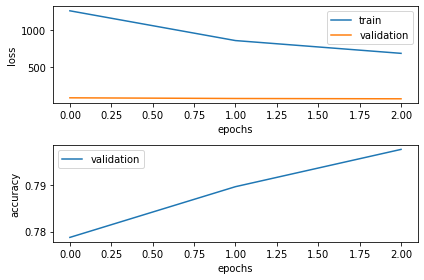

In [28]:
plt.subplot(2, 1, 1)
plt.plot([train_loss for _, train_loss, _, _ in history], label="train")
plt.plot([eval_loss for _, _, eval_loss, _ in history], label="validation")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc="best")

plt.subplot(2, 1, 2)
plt.plot([eval_score for _, _, _, eval_score in history], label="validation")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc="best")

plt.tight_layout()
_ = plt.show()

## Evaluation

In [29]:
ytrue, ypred = [], []
for batch in test_dl:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
      outputs = model(**batch)
      predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
      labels = batch["labels"].cpu().numpy()
      ytrue.extend(labels)
      ypred.extend(predictions)

print("test accuracy: {:.3f}".format(accuracy_score(ytrue, ypred)))

test accuracy: 0.801


In [30]:
print(classification_report(ytrue, ypred, target_names=valid_relations))

                          precision    recall  f1-score   support

administrative_divisions       0.59      0.68      0.63       323
                 capital       0.83      0.62      0.71       397
                 company       0.98      0.96      0.97       339
                 country       0.69      0.83      0.76       332
             nationality       0.91      0.92      0.91       423
         neighborhood_of       0.99      0.98      0.99       321
             place_lived       0.84      0.82      0.83       454
          place_of_birth       0.55      0.48      0.51       173
          place_of_death       0.48      0.57      0.52        82

                accuracy                           0.80      2844
               macro avg       0.76      0.76      0.76      2844
            weighted avg       0.81      0.80      0.80      2844



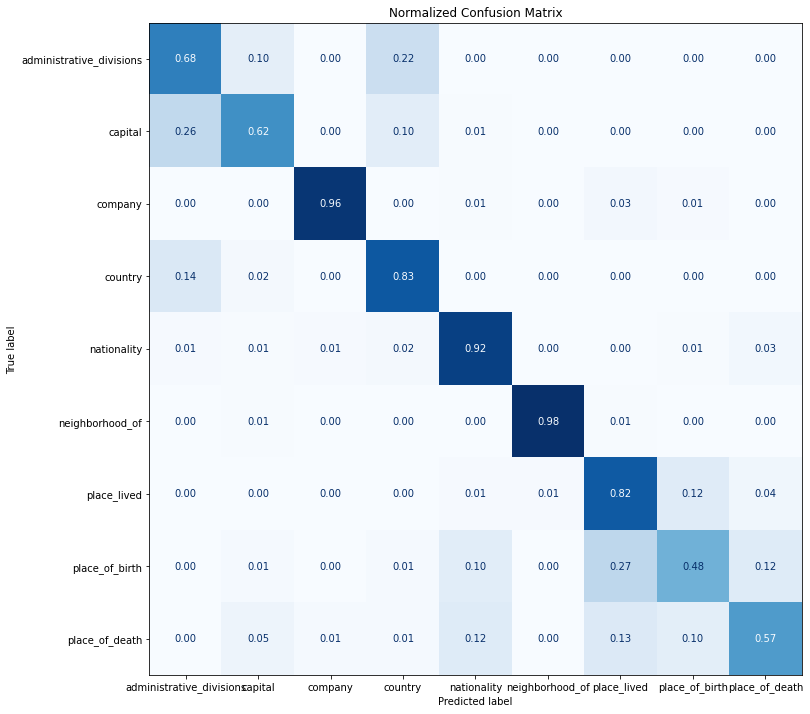

In [31]:
def plot_confusion_matrix(ytrue, ypreds, labels):
  cm = confusion_matrix(ytrue, ypreds, normalize="true")
  fig, ax = plt.subplots(figsize=(12, 12))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format="0.2f", ax=ax, colorbar=False)
  plt.title("Normalized Confusion Matrix")
  _ = plt.show()


plot_confusion_matrix(ytrue, ypred, valid_relations)

## Save Model

In [32]:
!cp -r data/bert-base-cased-nyt-re-v2/ /content/drive/MyDrive/odsc-2022-data/NYT/

In [33]:
!ls /content/drive/MyDrive/odsc-2022-data/NYT/bert-base-cased-nyt-re-v2/

ckpt-1	ckpt-2	ckpt-3	history.tsv
